In [1]:
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)
print(f"hello, GPU? {jax.devices()}", )

cuda? [cuda(id=0)] NVIDIA GeForce GTX 1050
hello, GPU? [cuda(id=0)]


2024-05-07 12:15:37.353170: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# Test-configuration
dataset_size = 100
test_resolution = 500


# Train-configuration
num_posterior_mc = 10  # number of latents to sample from p(Z | X, Y)
batch_size = 256  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 128
num_context_samples = 256


f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

#print(f1,f2)
#print(m,nm)
rng = jax.random.key(0)
print(rng)

### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'params': key_param, 'default': key_rng}, jnp.zeros(()))
    print("printing mixture params", params)
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

Array((), dtype=key<fry>) overlaying:
[0 0]


printing mixture params {'params': {'branches_0': {'module': {'module': {'amplitude': Array([0.5408695, 0.4742303], dtype=float32), 'shift': Array(2.449215, dtype=float32), 'phase': Array([1.9548615], dtype=float32)}}}, 'branches_1': {'module': {'module': {'amplitude': Array([0.5828917 , 0.530668  , 0.34191656], dtype=float32), 'shift': Array(1.0906379, dtype=float32), 'phase': Array([0.5698967, 3.0748522], dtype=float32)}}}}}


<Axes: xlabel='None', ylabel='None'>

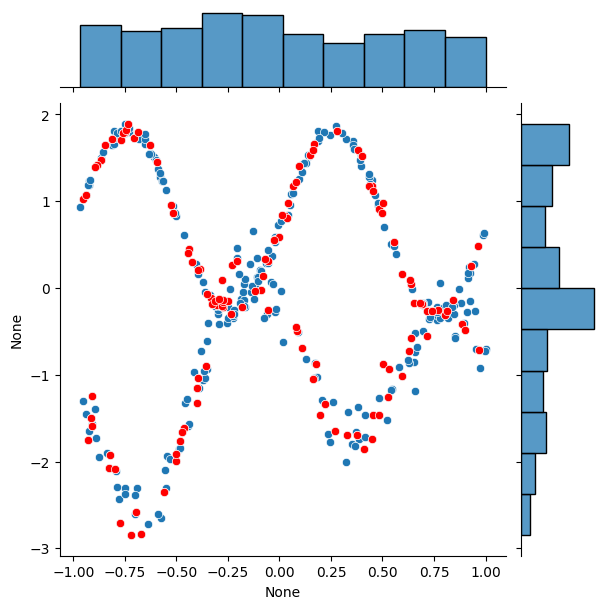

In [7]:
data_sampler = partial(
    joint, 
    Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)


rng, key = jax.random.split(rng)
xs, ys = data_sampler(key)

# X, Y are the context points (these will be inputted to create latent variable in NP model z ), and x_target and y_target are what we use for training , 
X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))

sns.jointplot(x=xs, y=ys)
sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

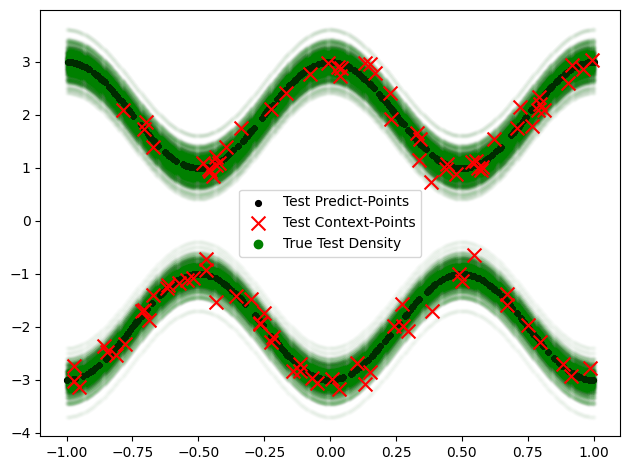

In [8]:

def f(
    key: flax.typing.PRNGKey,
    x: jax.Array,
    noise_scale: float = 0.2,
    mixture_prob: float = 0.5,
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)

    noise = jax.random.normal(key, x.shape) * noise_scale
    choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


rng, key_data, key_test, key_x = jax.random.split(rng, 4)


keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

# uniformly sample form -1 to 1
xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
# apply f to the uniformly created points xs
ys = jax.vmap(f)(keys_data, xs)

# create test_resolution test x points between -1 1
x_test = jnp.linspace(-1, 1, test_resolution)
# apply the function to it , but dont corrupt the output with noise now
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# this way the trainging data will be noisy, but test data wont be at all.

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T,
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Construct the NP model


#  context encoders, they are creating a latent representation of the input + related context


embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)


embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)


# so this project Yt , from the context aggregation r + Xt for current input ?
projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))

output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([128, 128, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)

# decoder ?
projection_outputs = NonLinearMVN(output_model)

# aggregator ? r ?
posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both,
    posterior_aggregator,
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (384, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (384, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,),

/tmp/ipykernel_17255/3269399017.py:43: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


In [13]:
# Lets create a data loader class for our training data

# Lets define a small pre computed dataset to try with.

# lets make 1000 function datasets for now
rng,key_data = jax.random.split(rng)
xst, yst = jax.vmap(data_sampler)(jax.random.split(key_data, num=256*1))
xst, yst = xst[..., None], yst[..., None]

# Split into context- and target-points.
X, x_testt = jnp.split(xst, indices_or_sections=(num_context_samples, ), axis=1)
y, y_testt = jnp.split(yst, indices_or_sections=(num_context_samples, ), axis=1)
#print(xst.shape,yst.shape, X.shape,x_test.shape, y.shape, y_test.shape)
#print(xst[0].shape)
#print(jnp.stack((xst,yst)).shape)

class TrainingData:
    def __init__(self, X, x_test, y, y_test):
        self.X = X
        self.x_test = x_test
        self.y = y
        self.y_test = y_test

    def __getitem__(self, idx):
        # This method allows the TrainingData instance to be indexable
        # It returns the components corresponding to the given index
        return (self.X[idx], self.x_test[idx], self.y[idx], self.y_test[idx])

    def __len__(self):
        # This method allows us to use len() on the TrainingData instance
        return self.X.shape[0]


    def fetch_batch(self , rng_key, batch_size):
      data_length = self.X.shape[0]
      batch_indeces = jax.random.choice(rng_key,data_length, shape=(batch_size,), replace=False)
      X_batch = self.X[batch_indeces]
      x_test_batch = self.x_test[batch_indeces]
      y_batch = self.y[batch_indeces]
      y_test_batch = self.y_test[batch_indeces]

      return (X_batch,y_batch,x_test_batch,y_test_batch)

    def reorder_data(self, rng_key, model, params):

        key, key_model = jax.random.split(rng_key)
        elbos = jax.vmap(partial(
        model.apply,
        params,
        beta=kl_penalty, k=num_posterior_mc,
        method=model.elbo
        ))(
          self.X, self.y, self.x_test, self.y_test, rngs={'default': jax.random.split(key_model, num=self.X.shape[0])}
        )
        return elbos

training_data = TrainingData(X,x_testt,y,y_testt)

rng, batch_k = jax.random.split(rng)
#print(training_data.fetch_batch(batch_k,25)[0].shape)

printing mixture params {'params': {'branches_0': {'module': {'module': {'amplitude': Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/0)> with
  val = Array([[1.61787510e-01, 2.70870090e-01],
       [3.74931335e-01, 7.71008730e-01],
       [4.74493980e-01, 2.23657012e-01],
       [8.93940568e-01, 1.73350692e-01],
       [6.38687611e-01, 9.53707814e-01],
       [7.51102686e-01, 1.41282797e-01],
       [7.76917934e-02, 7.74955988e-01],
       [6.83649540e-01, 9.77653146e-01],
       [3.39700341e-01, 1.88067555e-01],
       [1.48413658e-01, 1.72028542e-02],
       [1.82307839e-01, 8.88530850e-01],
       [5.13848901e-01, 2.25391507e-01],
       [9.96999979e-01, 4.83823180e-01],
       [6.68036938e-03, 4.43135023e-01],
       [4.45624709e-01, 4.03902292e-01],
       [5.87129235e-01, 4.70655441e-01],
       [6.04908943e-01, 6.00948334e-02],
       [5.84537029e-01, 8.67807984e-01],
       [6.13855124e-02, 4.46977377e-01],
       [7.24837303e-01, 8.00201893e-02],
       [2.62809634e-01

In [10]:
#Steps to implement self paced learning

# Firstly we have parameters
  # growth_epoch = Integer for epoch when the sampled data reaches 1.0 proportion , so whole dataset.
  # growth function (for now just have it be linear)


# Lets figure out how we can get a per sample loss calculated.

def posterior_loss_spl(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    pace : float,
    curr_data ,
    sampling_fun: Callable[
        [flax.typing.PRNGKey],
        tuple[jax.Array, jax.Array]
    ] = data_sampler


):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    #xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    #xs, ys = xs[..., None], ys[..., None]

    # Split into context- and target-points.
    #X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    #y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # curr_data has the same format of X,y,x_test,y_test , but its in a tuple

    X = curr_data[0]
    y = curr_data[1]
    x_test = curr_data[2]
    y_test = curr_data[3]

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply,
        params,
        beta=kl_penalty, k=num_posterior_mc,
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Compute sample weights based on the elbo and a dynamic lambda threshold
    weights = jnp.where(elbos < pace, 1.0, 0.0)  # Simple binary weights based on threshold

    # Apply weights to ELBOs
    weighted_elbos = weights * elbos

    # Compute the weighted loss, considering only selected samples
    return -jnp.mean(weighted_elbos)


@jax.jit
def step_spl(
    theta: flax.typing.VariableDict,
    opt_state: optax.OptState,
    random_key: flax.typing.PRNGKey,
    pace: float,
    curr_data
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step

    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss_spl, argnums=0)(theta, random_key,pace,curr_data)
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    return theta, opt_state, value

In [11]:
# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key},
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)
pace = 0.01
best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(1000, desc='Optimizing params. ')):

    # lets get a batch of data from our training data. randomly select 256 training points
    rng, batch_k = jax.random.split(rng)

    curr_batch = training_data.fetch_batch(batch_k,256)


    rng, key = jax.random.split(rng)
    params_new, opt_state, loss = step_spl(params, opt_state, key,pace,curr_batch)

    losses.append(loss)

    if loss < best:
        best = loss
        best_params = params_new

    if jnp.isnan(loss):
        break
    else:
        params = params_new
    pace+=0.001
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[ 467416311 3083572527]


Optimizing params. :   0%|          | 0/1000 [00:00<?, ?it/s]2024-05-07 12:27:42.438028: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 1.39GiB (1488057329 bytes) by rematerialization; only reduced to 1.78GiB (1907131292 bytes), down from 2.97GiB (3192297536 bytes) originally
2024-05-07 12:27:54.153003: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.93GiB (rounded to 2072082688)requested by op 
2024-05-07 12:27:54.153241: W external/tsl/tsl/framework/bfc_allocator.cc:494] *****_______________________________________________________________________________________________
E0507 12:27:54.154200   17255 pjrt_stream_executor_client.cc:2809] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2072082440 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.97MiB
              constant allocation:     

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2072082440 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.97MiB
              constant allocation:         0B
        maybe_live_out allocation:    1.22MiB
     preallocated temp allocation:    1.93GiB
  preallocated temp fragmentation:    1.25MiB (0.06%)
                 total allocation:    1.93GiB
              total fragmentation:    2.43MiB (0.12%)
Peak buffers:
	Buffer 1:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_1/module/Sequential_0/Dense_1/dot_general[dimension_numbers=(((3,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[327680,128]
		==========================

	Buffer 2:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_1/module/Sequential_0/Dense_0/dot_general[dimension_numbers=(((3,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[327680,128]
		==========================

	Buffer 3:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/module/Sequential_0/Dense_1/dot_general[dimension_numbers=(((3,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[327680,128]
		==========================

	Buffer 4:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/module/Sequential_0/Dense_0/dot_general[dimension_numbers=(((3,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[327680,128]
		==========================

	Buffer 5:
		Size: 160.00MiB
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 6:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_1/LayerNorm_0/add" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=204 deduplicated_name="input_subtract_transpose_fusion"
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 7:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/transpose(jvp(vmap(MixtureNeuralProcess.elbo)))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_2/dot_general[dimension_numbers=(((3,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274 deduplicated_name="input_transpose_fusion"
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 8:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_1/sub" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/networks.py" source_line=125
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 9:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/LayerNorm_0/add" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=204 deduplicated_name="input_subtract_transpose_fusion"
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 10:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/LayerNorm_0/add" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=204 deduplicated_name="input_subtract_transpose_fusion"
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 11:
		Size: 160.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/sub" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/networks.py" source_line=125
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 12:
		Size: 40.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_1/sub" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/networks.py" source_line=125
		XLA Label: fusion
		Shape: pred[256,10,128,128]
		==========================

	Buffer 13:
		Size: 40.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.predictive/vmap(vmap(likelihood.<lambda>))/likelihood/projection/layers_0/module/Sequential_0/jit(leaky_relu)/ge" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/combinators.py" source_line=112
		XLA Label: fusion
		Shape: pred[256,10,128,128]
		==========================

	Buffer 14:
		Size: 24.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.posterior/vmap(embed_both.<lambda>)/embed_both/Sequential_0/Dense_1/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[98304,64]
		==========================

	Buffer 15:
		Size: 24.00MiB
		Operator: op_name="jit(step_spl)/jit(main)/jvp(vmap(MixtureNeuralProcess.elbo))/MixtureNeuralProcess.posterior/vmap(embed_both.<lambda>)/embed_both/Sequential_0/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=274
		XLA Label: custom-call
		Shape: f32[98304,64]
		==========================



In [14]:
print(training_data.reorder_data(rng,model,params).shape)

2024-05-07 12:29:00.934272: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 160.00MiB (rounded to 167772160)requested by op 
2024-05-07 12:29:00.935329: W external/tsl/tsl/framework/bfc_allocator.cc:494] ****************************xxxx********************************************************xxxxxxxxxxxx
E0507 12:29:00.935455   17255 pjrt_stream_executor_client.cc:2809] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 167772160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  160.00MiB
              constant allocation:         0B
        maybe_live_out allocation:  160.00MiB
     preallocated temp allocation:         0B
                 total allocation:  320.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 160.00MiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=3]" so

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 167772160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  160.00MiB
              constant allocation:         0B
        maybe_live_out allocation:  160.00MiB
     preallocated temp allocation:         0B
                 total allocation:  320.00MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 160.00MiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=3]" source_file="/home/aszi/Github/CL_for_faster_Meta-learning/networks.py" source_line=20
		XLA Label: fusion
		Shape: f32[256,10,128,128]
		==========================

	Buffer 2:
		Size: 80.00MiB
		Entry Parameter Subshape: f32[256,10,128,64]
		==========================

	Buffer 3:
		Size: 80.00MiB
		Entry Parameter Subshape: f32[256,10,128,64]
		==========================

